# 1. IMPORT LIBRARIES & SETUP

In [37]:
!pip install nltk scikit-learn matplotlib seaborn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Download NLTK resources
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
# ensure these were executed before saving
best_model_name = results_df['Accuracy'].idxmax()
best_model = models[best_model_name]


In [26]:
import joblib

joblib.dump(best_model, "best_spam_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 2. DATASET SUMMARY (FROM ONLINE SOURCE)

In [ ]:
# Dataset Source: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])
print("✅ Dataset Loaded Successfully!")
df.head()

3. EXPLORATORY DATA ANALYSIS (EDA)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5572 non-null   object
 1   message    5572 non-null   object
 2   cleaned    5572 non-null   object
 3   label_num  5572 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 174.3+ KB
None

Class Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


/tmp/ipython-input-429945280.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


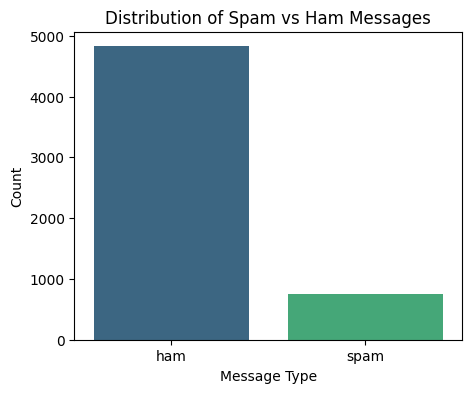

In [18]:
print("\nDataset Info:")
print(df.info())

print("\nClass Distribution:")
print(df['label'].value_counts())

# Visualize class distribution
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Distribution of Spam vs Ham Messages")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.show()

4. TEXT PREPROCESSING

In [17]:
def clean_text(text):
    text = text.lower()
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

df['cleaned'] = df['message'].apply(clean_text)
df['label_num'] = df['label'].map({'ham':0, 'spam':1})
df.head()

,label,message,cleaned,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...,1
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though,0


5. FEATURE EXTRACTION USING TF-IDF

In [19]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['cleaned']).toarray()
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shape of Training Data:", X_train.shape)
print("Shape of Testing Data:", X_test.shape)

Shape of Training Data: (4457, 3000)
Shape of Testing Data: (1115, 3000)


6. MODEL TRAINING (MULTIPLE MODELS)

In [20]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = [acc, prec, rec, f1]
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))



===== Naive Bayes =====
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.86      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.72      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95

7. MODEL PERFORMANCE COMPARISON


Model Comparison:


,Accuracy,Precision,Recall,F1
Naive Bayes,0.981166,1.000000,0.859060,0.924188
Logistic Regression,0.962332,0.990826,0.724832,0.837209
Random Forest,0.980269,1.000000,0.852349,0.920290
SVM,0.985650,0.985401,0.906040,0.944056


/tmp/ipython-input-2983375317.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df['Accuracy'], palette='mako')


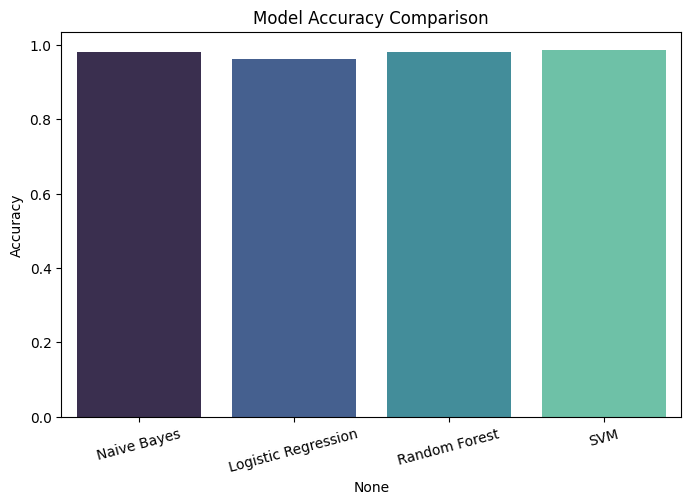

In [21]:
results_df = pd.DataFrame(results, index=['Accuracy','Precision','Recall','F1']).T
print("\nModel Comparison:")
display(results_df)

# Visualization
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df['Accuracy'], palette='mako')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.show()



8. CONFUSION MATRIX (BEST MODEL)

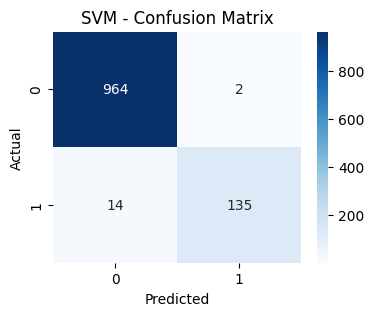

✅ Best Model Identified: SVM


In [22]:
best_model_name = results_df['Accuracy'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'{best_model_name} - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"✅ Best Model Identified: {best_model_name}")



9. TEST WITH NEW SAMPLE MESSAGES

In [23]:
sample_msgs = [
    "Congratulations! You've won a $500 Amazon gift card. Click the link to claim now!",
    "Hey, are we still going to class tomorrow?",
    "URGENT! Your account will be locked. Verify immediately!",
    "Lunch at 1 pm sound good?"
]

sample_cleaned = [clean_text(msg) for msg in sample_msgs]
sample_tfidf = tfidf.transform(sample_cleaned).toarray()
predictions = best_model.predict(sample_tfidf)

for msg, pred in zip(sample_msgs, predictions):
    label = "SPAM" if pred == 1 else "HAM"
    print(f"\nMessage: {msg}\nPrediction: {label}")



Message: Congratulations! You've won a $500 Amazon gift card. Click the link to claim now!
Prediction: SPAM

Message: Hey, are we still going to class tomorrow?
Prediction: HAM

Message: URGENT! Your account will be locked. Verify immediately!
Prediction: SPAM

Message: Lunch at 1 pm sound good?
Prediction: HAM


10. SAVE MODEL & VECTORIZER

In [24]:
joblib.dump(best_model, "best_spam_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print(f"\n Project Completed Successfully!")
print(f"Best Model Saved: {best_model_name}")


 Project Completed Successfully!
Best Model Saved: SVM
